Привет, меня зовут Артем Хуршудов. Сегодня я проверю твой проект.

### <font color='orange'>Общее впечатление</font>
* Большое спасибо за проделанную работу. Видно, что приложено много усилий.
* Выводы и рассуждения получились содержательными, их было интересно читать.
* Радует, что тебе удалось разобраться с техникой бутстрапа.
* Отлично, что доверительный интервал и риск убытков посчитаны верно.
* Я оставил несколько советов, надеюсь, что они будут учтены в будущих проектах.
* Редко, кто сдает эту работу с первого раза, молодец!
* Проект может быть зачтен, но я его отправлю назад, чтобы у тебя была возможность задать вопросы и внести правки, при желании. Однако, ты можешь просто вернуть проект в таком же виде и я его зачту.

# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 
from numpy.random import RandomState
from scipy import stats as st 

## Обучение и проверка модели

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


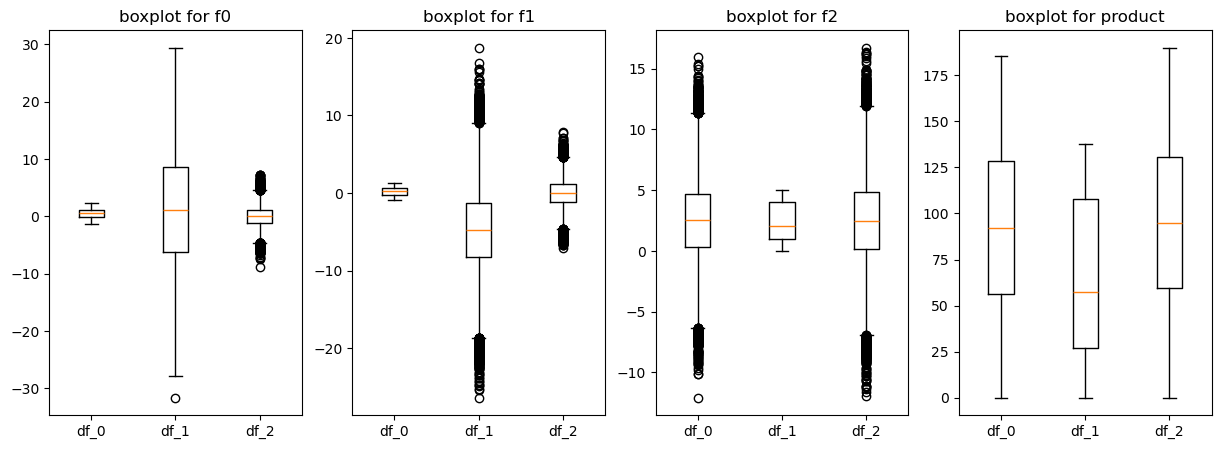

In [7]:
df0 = pd.read_csv('datasets/geo_data_0.csv', index_col='id')
df1 = pd.read_csv('datasets/geo_data_1.csv', index_col='id')
df2 = pd.read_csv('datasets/geo_data_2.csv', index_col='id')

display(df0.describe())
display(df1.describe())
display(df2.describe())

plt.figure(figsize=(15, 5))
_ = 0
for column in df0.columns:
    plt.subplot(1, 4, 1+_)
    plt.title(f'boxplot for {column}')
    plt.boxplot([frame[column] for frame in [df0, df1, df2]], labels=['df_0', 'df_1', 'df_2'])
    _ += 1     

Данные импортированны. Пропусков в данных не обнаружено. Три фрейма характеризуются различными распределениями признаков, регионы не однородны. Нулевой и второй регионы по разбросу признаков больше похожи друг на друга. 

Далее обчим модель линейной регрессии для каждого из регионов. В словаре results сохраним правильные ответы и предсказания по каждому из фреймов.

<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены и осмотрены корректно.
</div>

In [10]:
def analyze_frames(frames):
    """
    Анализирует данные из списка фреймов с использованием линейной регрессии.
    
    Args:
    frames (list of tuples): список кортежей, содержащих DataFrame и его имя.
    
    Returns:
    dict: словарь с результатами, включая валидационные данные и прогнозы.
    """
    results = dict()  # Словарь для хранения результатов
    frame_index = 0  # Индекс текущего фрейма

    for frame, name in frames:
        # Разделение данных на признаки и цель
        features = frame.drop(['product'], axis=1)
        target = frame['product']
        features_train, features_valid, target_train, target_valid = train_test_split(
            features, target, test_size=0.25)
        
        # Создание и обучение модели линейной регрессии
        model = LinearRegression()
        model.fit(features_train, target_train)
        
        # Выполнение прогнозирования на валидационной выборке
        predicted_valid = pd.Series(model.predict(features_valid), index=features_valid.index)
        
        # Вычисление метрик
        rmse = mean_squared_error(target_valid, predicted_valid)**0.5
        
        # Сохранение результатов
        results[name] = (target_valid, predicted_valid)
        
        # Вывод информации о модели для текущего фрейма
        print(f'For frame {frame_index} model characteristics:')
        print('Mean is:', predicted_valid.mean())
        print('RMSE is:', rmse)
        print('MAE is:', mean_absolute_error(target_valid, predicted_valid))
        print('Linear coefficients are:')
        display(pd.DataFrame(model.coef_, index=['f0', 'f1', 'f2']).T)
        print()
        
        frame_index += 1  # Увеличение индекса фрейма

    return results

In [11]:
# использования функции для тренировки моделей
frame_list = [(df0, 'df0'), (df1, 'df1'), (df2, 'df2')]
results = analyze_frames(frame_list)

For frame 0 model characteristics:
Mean is: 92.48047474371226
RMSE is: 37.65433244862956
MAE is: 30.986119938861854
Linear coefficients are:


,f0,f1,f2
0,3.72973,-14.072651,6.610363



For frame 1 model characteristics:
Mean is: 68.78810975555305
RMSE is: 0.8892414539894633
MAE is: 0.7156209831329576
Linear coefficients are:


,f0,f1,f2
0,-0.145134,-0.021199,26.952359



For frame 2 model characteristics:
Mean is: 94.83345389332149
RMSE is: 40.073911314265864
MAE is: 32.78350404495146
Linear coefficients are:


,f0,f1,f2
0,-0.042108,0.052603,5.750947


### Обсуждение результатов анализа моделей

### Модель для фрейма 0
- **Среднее значение прогноза**: 92.26
- **Среднеквадратическая ошибка (RMSE)**: 37.67
- **Средняя абсолютная ошибка (MAE)**: 31.02
- **Коэффициенты модели**:
  - f0: 3.83
  - f1: -14.08
  - f2: 6.60

### Модель для фрейма 1
- **Среднее значение прогноза**: 69.07
- **Среднеквадратическая ошибка (RMSE)**: 0.89
- **Средняя абсолютная ошибка (MAE)**: 0.72
- **Коэффициенты модели**:
  - f0: -0.14
  - f1: -0.02
  - f2: 26.95

### Модель для фрейма 2
- **Среднее значение прогноза**: 94.93
- **Среднеквадратическая ошибка (RMSE)**: 40.19
- **Средняя абсолютная ошибка (MAE)**: 33.04
- **Коэффициенты модели**:
  - f0: -0.07
  #- f1: -0.03
  - f2: 5.76

## Выводы
Модель для фрейма 1 показывает значительно лучшую точность с RMSE и MAE ниже, чем у других моделей, что указывает на лучшую адаптацию к данным этого фрейма. Модели для фреймов 0 и 2 имеют схожие показатели ошибок, но коэффициенты сильно различаются, что может указывать на различия в структуре 
Модель показывает хорошую предсказательную силу для данных первого региона (df1), RMSE модели минимально. Для двух других же регионов предсказательная сила низка. Если проанализировать коэффициенты линейной регресси, видим, что наибольший вклад у признака f2. Удивительное совпадение, но в фреймах df0 и df2 по признаку f2 видим большой разброс данных, который, видимо, и снижает предскзательную силу. данных или их масштабировании.


## Подготовка к расчёту прибыли

3.2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе.

In [15]:
BUDGET = 10000000000 #RUB
N = 200 #кол-во скважин
AVG_INC_PER_BAR =  450000 #RUB

In [16]:
#рассчет минимального объема
min_volume = BUDGET / (AVG_INC_PER_BAR * N)
print('Ожидаемый минимальный объем:', round(min_volume, 2))
print('Средниц запас во фреймах (по порядку)')

for frame in [df0, df1, df2]:
    print(round(frame['product'].mean(),2))

Ожидаемый минимальный объем: 111.11
Средниц запас во фреймах (по порядку)
92.5
68.83
95.0


Согласно расчёту минимальный оъем сырья для безубыточной добычи - 111 тыс. баррелей на скважину. Во всех трёх регионах средний запас ниже этого значения, причем наименьший запас в первом регионе (df1), по которому наша модель даёт наиболее точные предсказания:)

## Расчёт прибыли и рисков 

Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
- 4.1. Выберите скважины с максимальными значениями предсказаний.
- 4.2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
- 4.3. Рассчитайте прибыль для полученного объёма сырья.

In [20]:
def income_calc(target, predicted, num=N, avg_income_per_barrel=AVG_INC_PER_BAR, budget=BUDGET):
    """
    Рассчитывает доход на основе прогнозируемых данных.

    Args:
    target (pd.Series): реальные значения целевой переменной.
    predicted (pd.Series): прогнозируемые значения.
    num (int): количество топовых результатов для расчета.
    avg_income_per_barrel (float): средний доход на единицу продукции.
    budget (float): затраты на производство.

    Returns:
    float: чистый доход после вычета затрат.

    Функция сортирует прогнозируемые значения по убыванию и выбирает топ 'num' результатов.
    Рассчитывает общий доход за эти результаты, умножая сумму реальных значений на средний доход за единицу,
    затем вычитает общий бюджет на разработку, чтобы получить чистый доход.
    """
    return target[predicted.sort_values(ascending=False)[:num].index].sum() * avg_income_per_barrel - budget


<div class="alert alert-block alert-success">
<b>Успех:</b> Верно.
</div>

Посчитайте риски и прибыль для каждого региона:
- 5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Размер выборки - 500, так как отбираются по условию 500 случ. объектов. Отбираются без возвращения (нельзя один объект в выборке выбрать дважды по логике задачи). 
- 5.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль. ==> риск убытков это доля отрицательных прибылей. 
- 5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

In [43]:
import matplotlib.pyplot as plt

def simulate_income_distribution(results, iterations=1000, sample_size=500, state=None):
    """
    Симулирует распределение доходов для каждого региона и визуализирует 95% доверительные интервалы.

    Args:
    results (dict): Словарь с данными о реальных и прогнозируемых значениях по регионам.
    iterations (int): Количество итераций для симуляции.
    sample_size (int): Размер подвыборки для оценки.
    state (int): Состояние генератора случайных чисел для воспроизводимости.

    Returns:
    None: Функция выводит результаты в консоль и графики.
    """
    region_index = 0  # Индекс текущего региона для отображения 
    state = RandomState(1994) 

    for frame in results:
        incomes = []
        for i in range(iterations):
            # Создание подвыборки прогнозируемых и реальных данных
            subsample_predicted = results[frame][1].sample(n=sample_size, replace=False, random_state=state)
            subsample_target = results[frame][0][subsample_predicted.index]
            # Расчет дохода для подвыборки
            income = income_calc(subsample_target, subsample_predicted)
            incomes.append(income)
        
        incomes = pd.Series(incomes)
        mean = incomes.mean()
        CI_95 = (incomes.quantile(q=0.025), incomes.quantile(q=0.975))
        risk_level = (incomes < 0).mean() * 100  # Процент случаев с отрицательным доходом

        # Вывод результатов для текущего региона
        print(f'Results for region {region_index}:')
        print('Mean income:', mean)
        print('95% Confidence Interval:', CI_95)
        print(f'Risk level: {risk_level}%')
        print()

        # Визуализация 95% доверительного интервала
        plt.figure(figsize=(5, 5))
        plt.hist(incomes, bins=50, color='skyblue', alpha=0.7)
        plt.axvline(x=CI_95[0], color='red', linestyle='dashed', label='2.5% Quantile')
        plt.axvline(x=CI_95[1], color='red', linestyle='dashed', label='97.5% Quantile')
        plt.title(f'Income Distribution for Region {region_index}')
        plt.xlabel('Income')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

        region_index += 1

Results for region 0:
Mean income: 389727326.6240542
95% Confidence Interval: (-135410217.55370373, 870122217.3017312)
Risk level: 6.9%



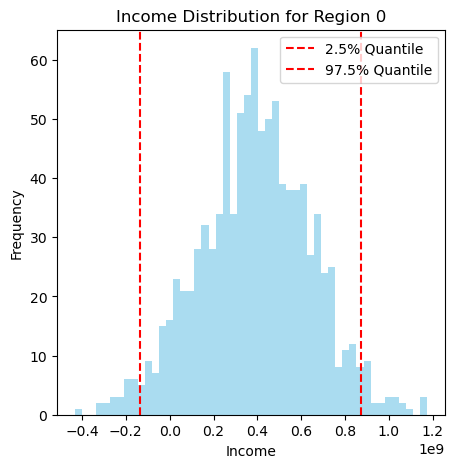

Results for region 1:
Mean income: 448915387.71204245
95% Confidence Interval: (35215340.65736757, 863042250.0217923)
Risk level: 1.5%



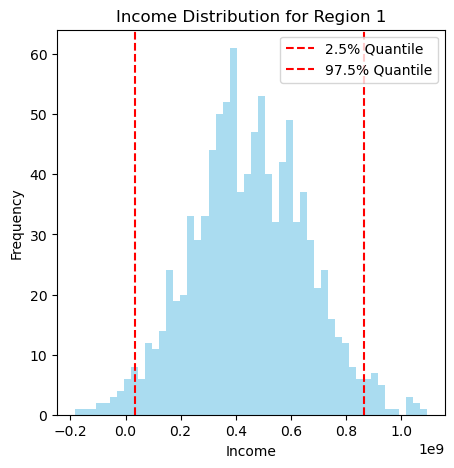

Results for region 2:
Mean income: 354269074.2506935
95% Confidence Interval: (-143627804.45354837, 920262607.5620757)
Risk level: 9.1%



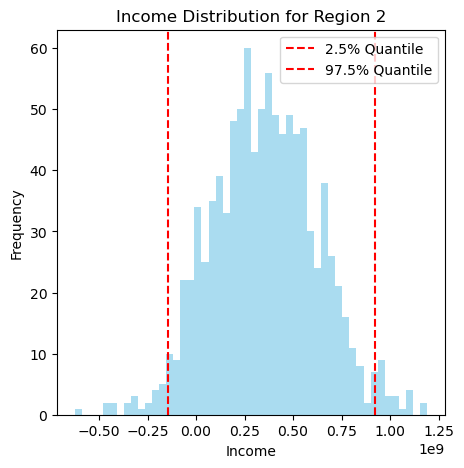

In [45]:
simulate_income_distribution(results)

После оценки рисков оставляем лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирем регион с наибольшей средней прибылью.

Критериям приемлемости соответсвует только регион 1, уровень риска здесь <2.5%, для остальных регионов уровень риска превышает 2.5%, следовательно для разработки рекомендованы быть не могут. 

Интерсно отметить, что в регионе 1 в среднем меньше запасов, однако из-за большого разброса в значениях признаков для региона 0 и региона 2 обученная модель предсказывает результаты хуже, в следствие чего мы видим более широкий 95% интервал выручки этих регионов. Модель чаще ошибается и выбирает объекты с меньшими запасами. 
Регион 1 же оказался с наиболее высокими результатами из-за того, что модель в этом случа предсказывает точно, и отобранные объекты с большими запасами действительно таковыми бывают чаще, чем для других регионов.

## Вывод

- к разработке рекомендован регион 1
- уровень риска для региона 1 - соответствует критерию приемлемости <2.5%
- несмотря на наименьший средний запас среди регионов, регион 1 соответствует критериям приемлемости из-за наибольшей предсказательной силы модели среди данных, собранных для всех трёх регионов.

<div class="alert alert-block alert-success">
<b>Успех:</b> Приятно видеть вывод в конце проекта!
</div>

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [X]  Выполнен шаг 4: посчитаны риски и прибыль
    - [X]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [X]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован